## UNZIPPING DATA

In [1]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.5 MB/s eta 0:00:00


In [2]:
!unzip archive.zip

Archive:  archive.zip
   creating: lfw_funneled/
   creating: lfw_funneled/George_HW_Bush/
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0004.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0005.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0006.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0007.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0008.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0009.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0010.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0011.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0012.jpg  
  inflating: lfw_funneled/George_HW_Bush/George_HW_Bush_0013.jpg  
   creating: lfw_funneled/Curtis_Stran

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random as rand
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import os
import cv2
from math import log10, sqrt
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.utils import to_categorical
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import mtcnn
from PIL import Image
from scipy import ndimage
from tqdm import tqdm

**LOADING MTCNN MODEL**

In [4]:
detector = mtcnn.MTCNN()

LOADING DATA AND EXTRACTING FACE FROM THE PICTURE

In [5]:
Training = []
Result_Training = []
for dirname, _, filenames in os.walk('/content/lfw_funneled/'):
    for filename in filenames:
        img = cv2.imread(os.path.join(dirname, filename))
        Result_Training.append(filename.split("_")[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = detector.detect_faces(img)
        x1, y1, h, w = result[0]["box"]
        x2, y2 = x1 + w, y1 + h
        face = img[y1:y2, x1:x2]
        print("Face Dimentions: ", face.shape)
        img = cv2.resize(face, (128, 128))
        Training.append(img)
np.array(Training).shape, np.array(Result_Training).shape

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (102, 139, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (96, 136, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (91, 136, 3)
1/1 [==============================] - 0s 20ms/step
Face Dimentions:  (102, 137, 3)
1/1 [==============================] - 0s 23ms/step
Face Dimentions:  (106, 144, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (97, 123, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (105, 140, 3)
1/1 [==============================] - 0s 19ms/step
Face Dimentions:  (94, 129, 3)
1/1 [==============================] - 0s 21ms/step
Face Dimentions:  (96, 130, 3)
1/1 [==============================] - 0s 29ms/step
Face Dimentions:  (97, 134, 3)
1/1 [==============================] - 0s 25ms/step
Face Dimentions:  (95, 128, 3)
1/1 [===========================

((621, 128, 128, 3), (621,))

# DATA PREPROCESSING

In [6]:
Result = Result_Training
np.array(Result).shape

(621,)

In [7]:
lb = LabelEncoder()
Result = lb.fit_transform(Result)

In [8]:
Temp = []
for i in Result:
    temp = []
    temp.append(i)
    Temp.append(temp)
output_matrix = to_categorical(Temp)
total = output_matrix.shape[1]
output_matrix.shape

(621, 48)

FUCTIONS FOR PSNR AND SSIM

In [9]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return round(psnr, 2)

In [10]:
def SSIMS(original, compressed):
  return round(ssim(original, compressed, multichannel=True), 2)

In [11]:
def Print_ALL(original, compressed):
  print("PSRN: ", PSNR(original, compressed))
  print("SSIM: ", SSIMS(original, compressed))

In [12]:
def Print_data(y_real, y_pre):
  cm = confusion_matrix(y_real, y_pre)
  for c in range(27):
      tp = cm[c,c]
      fp = sum(cm[:,c]) - cm[c,c]
      fn = sum(cm[c,:]) - cm[c,c]
      tn = sum(np.delete(sum(cm)-cm[c,:],c))

      recall = tp/(tp+fn)
      precision = tp/(tp+fp)
      specificity = tn/(tn+fp)
      f1_score = 2*((precision*recall)/(precision+recall))
      

      #print(f"for class {c}: acc {accuracy}, recall {recall},\
      #      precision {precision}, f1 {f1_score}")
      print("for class {}: recall {}, specificity {}\
            precision {}, f1 {}".format(c,round(recall,4), round(specificity,4), round(precision,4),round(f1_score,4)))

DOWNSAMPLING CODE FOR IMAGES TO CONVERT THEM TO LR

In [13]:
def down_sampling(ar, fact):
    res = ar[::fact, ::fact, :]
    return res

In [14]:
LR = []
for i in tqdm(range(len(Training)),desc="CONVERTING"):
  LR.append(down_sampling(Training[i], 4))
np.array(LR).shape

CONVERTING: 100%|██████████| 621/621 [00:00<00:00, 188771.04it/s]


(621, 32, 32, 3)

TRUTH GROUND IMAGES AND LR IMAGES

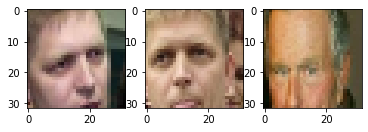

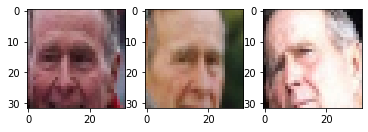

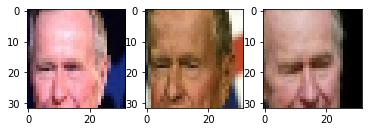

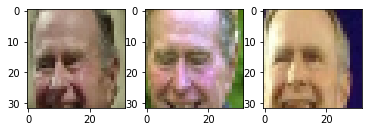

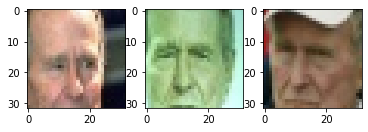

In [15]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(LR[i])
    plt.sca(axarr[1]); 
    plt.imshow(LR[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(LR[i+2])
    plt.show()

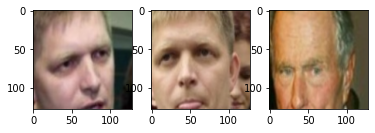

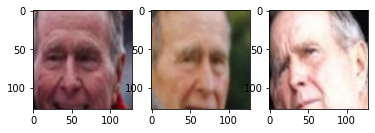

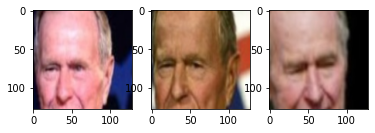

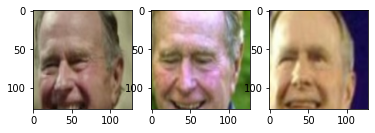

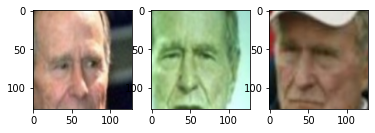

In [16]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Training[i])
    plt.sca(axarr[1]); 
    plt.imshow(Training[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Training[i+2])
    plt.show()

# LAPSRN

In [17]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/LapSRN_x4.pb')
super_res.setModel('lapsrn',4)

In [18]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:53<00:00, 11.65it/s]


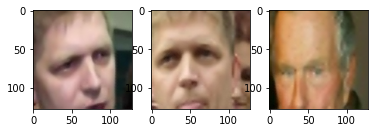

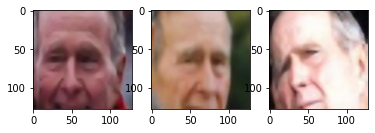

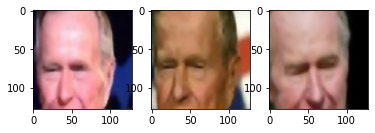

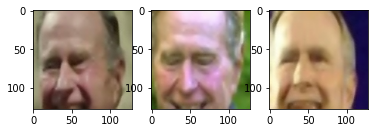

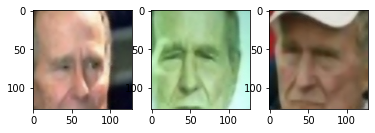

In [19]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULT OF UPSAMPLING**

In [20]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.14


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


**TAINING AND TESTING DATA**

In [21]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [22]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_8 (Dense)             (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 6s 57ms/step - loss: 5.6285 - accuracy: 0.2963 - precision: 0.3896 - recall: 0.2415
Epoch 2/20
20/20 [==============================] - 1s 36ms/step - loss: 1.6854 - accuracy: 0.6167 - precision: 0.8333 - recall: 0.4589
Epoch 3/20
20/20 [==============================] - 1s 36ms/step - loss: 0.9198 - accuracy: 0.7424 - precision: 0.8926 - recall: 0.6425
Epoch 4/20
20/20 [==============================] - 1s 35ms/step - loss: 0.4504 - accuracy: 0.9082 - precision: 0.9704 - recall: 0.7907
Epoch 5/20
20/20 [==============================] - 1s 35ms/step - loss: 0.3106 - accuracy: 0.9147 - precision: 0.9558 - recall: 0.8712
Epoch 6/20
20/20 [==============================] - 1s 34ms/step - loss: 0.1458 - accuracy: 0.9791 - precision: 0.9918 - recall: 0.9694
Epoch 7/20
20/20 [==============================] - 1s 35ms/step - loss: 0.0885 - accuracy: 0.9936 - precision: 0.9984 - recall: 0.9919
Epoch 8/20
20/20 [==============================

# IMPORTANT PLOTS

KeyError: ignored

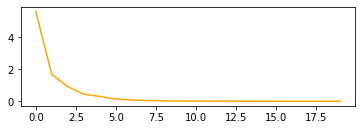

In [25]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision"], color='orange')
plt.plot(history.history["val_precision"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall"], color='green')
plt.plot(history.history["val_recall"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

# ANSWERS

In [26]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 39ms/step - loss: 0.0050 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
ACCURACY:  1.0
LOSS:  0.01
Precision:  1.0
Recall:  1.0


In [27]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 2s 33ms/step


In [28]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

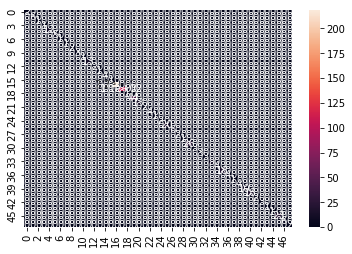

In [29]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [30]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

# MOBILENETv2

In [31]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [32]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 33ms/step - loss: 3.4149 - accuracy: 0.3011 - precision_1: 0.3985 - recall_1: 0.1675
Epoch 2/20
20/20 [==============================] - 0s 20ms/step - loss: 2.3047 - accuracy: 0.4187 - precision_1: 0.5368 - recall_1: 0.1643
Epoch 3/20
20/20 [==============================] - 0s 19ms/step - loss: 2.0690 - accuracy: 0.4493 - precision_1: 0.5983 - recall_1: 0.2254
Epoch 4/20
20/20 [==============================] - 0s 18ms/step - loss: 1.8993 - accuracy: 0.4750 - precision_1: 0.6615 - recall_1: 0.2738
Epoch 5/20
20/20 [==============================] - 0s 16ms/step - loss: 1.6865 - accuracy: 0.5250 - precision_1: 0.7554 - recall_1: 0.3382
Epoch 6/20
20/20 [==============================] - 0s 16ms/step - loss: 1.7427 - accuracy: 0.4928 - precision_1: 0.6186 - recall_1: 0.2899
Epoch 7/20
20/20 [==============================] - 0s 16ms/step - loss: 1.5231 - accuracy: 0.5636 - precision_1: 0.7450 - recall_1: 0.3623
Epoch 8/20
20/20 [==

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_1"], color='orange')
plt.plot(history.history["val_precision_1"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_1"], color='green')
plt.plot(history.history["val_recall_1"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [33]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 19ms/step - loss: 0.4542 - accuracy: 0.8808 - precision_1: 0.9341 - recall_1: 0.7987
ACCURACY:  0.88
LOSS:  0.45
Precision:  0.93
Recall:  0.8


In [34]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 15ms/step


In [35]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

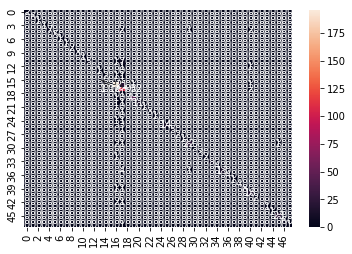

In [36]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [37]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.5833, specificity 1.0            precision 1.0, f1 0.7368
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.3846, specificity 1.0            precision 1.0, f1 0.5556
for class 12: recall 0.0, specificity 1.0            precision nan, f1 nan
for class 13: recall 1.

<ipython-input-12-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)


# EDSR MODEL

In [38]:
super_res = cv2.dnn_superres.DnnSuperResImpl_create()
super_res.readModel('/content/EDSR_x4.pb')
super_res.setModel('edsr',4)

In [39]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = super_res.upsample(LR[i])
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [15:01<00:00,  1.45s/it]


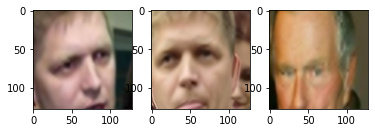

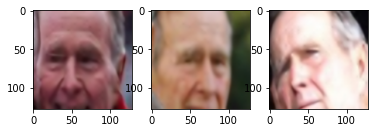

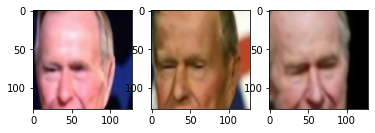

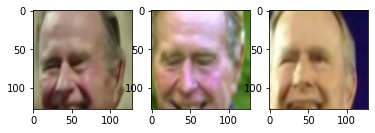

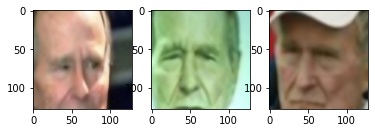

In [40]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**Comapring The SR result**

In [41]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.17


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


**TESTING AND TRAINING**

In [42]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [43]:
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [44]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_12 (Dense)            (None, 48)                98352     
                                                                 
Total params: 27,882,416
Trainable params: 4,294,704
Non-trainable params: 23,587,712
_________________________________________________________________


In [45]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 5s 39ms/step - loss: 4.9724 - accuracy: 0.3269 - precision_2: 0.4055 - recall_2: 0.2383
Epoch 2/20
20/20 [==============================] - 1s 35ms/step - loss: 1.3172 - accuracy: 0.6570 - precision_2: 0.8667 - recall_2: 0.5233
Epoch 3/20
20/20 [==============================] - 1s 35ms/step - loss: 0.7007 - accuracy: 0.8470 - precision_2: 0.9408 - recall_2: 0.7166
Epoch 4/20
20/20 [==============================] - 1s 36ms/step - loss: 0.3736 - accuracy: 0.9098 - precision_2: 0.9739 - recall_2: 0.8406
Epoch 5/20
20/20 [==============================] - 1s 36ms/step - loss: 0.1894 - accuracy: 0.9694 - precision_2: 0.9846 - recall_2: 0.9275
Epoch 6/20
20/20 [==============================] - 1s 37ms/step - loss: 0.1217 - accuracy: 0.9807 - precision_2: 0.9918 - recall_2: 0.9726
Epoch 7/20
20/20 [==============================] - 1s 36ms/step - loss: 0.0598 - accuracy: 0.9968 - precision_2: 0.9968 - recall_2: 0.9887
Epoch 8/20
20/20 [==

**graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_2"], color='orange')
plt.plot(history.history["val_precision_2"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_2"], color='green')
plt.plot(history.history["val_recall_2"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answer**

In [46]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 41ms/step - loss: 0.0036 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000
ACCURACY:  1.0
LOSS:  0.0
Precision:  1.0
Recall:  1.0


In [47]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 2s 36ms/step


In [48]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

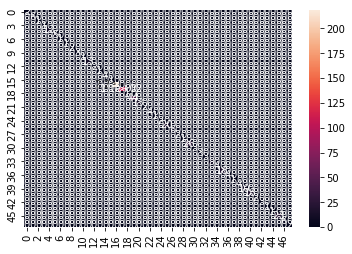

In [49]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [50]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, specifici

# MOBILENETv2

In [51]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [52]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 22ms/step - loss: 3.7949 - accuracy: 0.2786 - precision_3: 0.3036 - recall_3: 0.1481
Epoch 2/20
20/20 [==============================] - 0s 18ms/step - loss: 2.4351 - accuracy: 0.4155 - precision_3: 0.5411 - recall_3: 0.2013
Epoch 3/20
20/20 [==============================] - 0s 18ms/step - loss: 2.0736 - accuracy: 0.4863 - precision_3: 0.7050 - recall_3: 0.2271
Epoch 4/20
20/20 [==============================] - 0s 18ms/step - loss: 1.8891 - accuracy: 0.5024 - precision_3: 0.7287 - recall_3: 0.3027
Epoch 5/20
20/20 [==============================] - 0s 18ms/step - loss: 1.7198 - accuracy: 0.5314 - precision_3: 0.7500 - recall_3: 0.3140
Epoch 6/20
20/20 [==============================] - 0s 18ms/step - loss: 1.6283 - accuracy: 0.5572 - precision_3: 0.7655 - recall_3: 0.3575
Epoch 7/20
20/20 [==============================] - 0s 18ms/step - loss: 1.4461 - accuracy: 0.5910 - precision_3: 0.8253 - recall_3: 0.3881
Epoch 8/20
20/20 [==

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_3"], color='orange')
plt.plot(history.history["val_precision_3"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_3"], color='green')
plt.plot(history.history["val_recall_3"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**ANSWERS**

In [53]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 21ms/step - loss: 0.5236 - accuracy: 0.8325 - precision_3: 0.9018 - recall_3: 0.7391
ACCURACY:  0.83
LOSS:  0.52
Precision:  0.9
Recall:  0.74


In [54]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 14ms/step


In [55]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

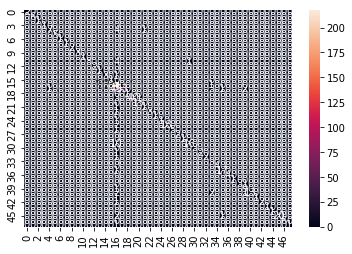

In [56]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [57]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.5833, specificity 0.9984            precision 0.875, f1 0.7
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.6154, specificity 1.0            precision 1.0, f1 0.7619
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 

# BICUBIC MODEL

In [58]:
Temp_Train = []
for i in tqdm(range(len(LR)),desc="UPSAMPLING"):
  img = cv2.resize(LR[i], (128, 128), interpolation=cv2.INTER_CUBIC)
  Temp_Train.append(img)

UPSAMPLING: 100%|██████████| 621/621 [00:00<00:00, 2733.38it/s]


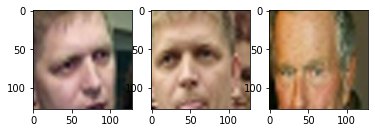

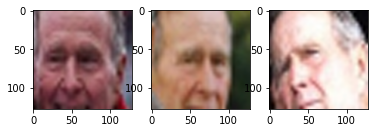

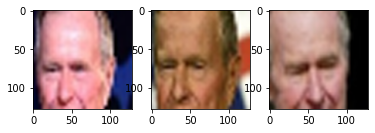

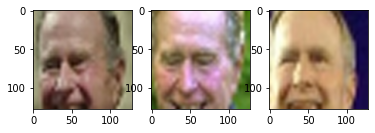

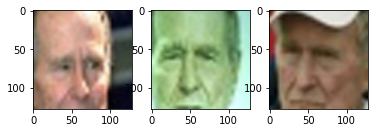

In [59]:
for i in range(0, 15, 3):
    f, axarr = plt.subplots(nrows=1,ncols=3)
    plt.sca(axarr[0]); 
    plt.imshow(Temp_Train[i])
    plt.sca(axarr[1]); 
    plt.imshow(Temp_Train[i+1])
    plt.sca(axarr[2]); 
    plt.imshow(Temp_Train[i+2])
    plt.show()

**RESULTS**

In [60]:
Print_ALL(np.array(Training), np.array(Temp_Train))

PSRN:  31.01


<ipython-input-10-f03d19e3d0da>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return round(ssim(original, compressed, multichannel=True), 2)


SSIM:  0.94


In [61]:
Temp_Train = np.array(Temp_Train)
output_matrix =  np.array(output_matrix)

# RESNET50 MODEL

In [62]:
resnet_model = Sequential()
pretrained_mRESULTSodel= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(2048, activation='relu'))
resnet_model.add(Dense(total, activation='softmax'))

In [63]:
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 2048)              2623488   
                                                                 
 dense_16 (Dense)            (None, 48)                98352     
                                                                 
Total params: 4,979,824
Trainable params: 2,721,840
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = resnet_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 9s 32ms/step - loss: 3.6338 - accuracy: 0.2931 - precision_4: 0.3373 - recall_4: 0.1353
Epoch 2/20
20/20 [==============================] - 0s 24ms/step - loss: 2.3570 - accuracy: 0.4187 - precision_4: 0.5946 - recall_4: 0.1771
Epoch 3/20
20/20 [==============================] - 1s 25ms/step - loss: 2.0230 - accuracy: 0.4799 - precision_4: 0.7110 - recall_4: 0.2496
Epoch 4/20
20/20 [==============================] - 0s 25ms/step - loss: 1.8341 - accuracy: 0.5266 - precision_4: 0.7935 - recall_4: 0.3156
Epoch 5/20
20/20 [==============================] - 1s 32ms/step - loss: 1.6578 - accuracy: 0.5620 - precision_4: 0.7900 - recall_4: 0.3575
Epoch 6/20
20/20 [==============================] - 1s 25ms/step - loss: 1.5102 - accuracy: 0.5990 - precision_4: 0.8481 - recall_4: 0.3865
Epoch 7/20
20/20 [==============================] - 1s 30ms/step - loss: 1.4572 - accuracy: 0.5878 - precision_4: 0.7508 - recall_4: 0.4026
Epoch 8/20
20/20 [==

**Graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_4"], color='orange')
plt.plot(history.history["val_precision_4"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_4"], color='green')
plt.plot(history.history["val_recall_4"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [65]:
answer = resnet_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 1s 16ms/step - loss: 0.3849 - accuracy: 0.8841 - precision_4: 0.9435 - recall_4: 0.8341
ACCURACY:  0.88
LOSS:  0.38
Precision:  0.94
Recall:  0.83


In [66]:
pre = resnet_model.predict(Temp_Train)

20/20 [==============================] - 1s 13ms/step


In [67]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

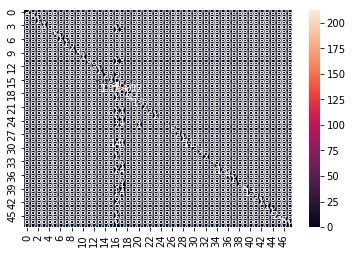

In [68]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [69]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.6667, specificity 1.0            precision 1.0, f1 0.8
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.6923, specificity 1.0            precision 1.0, f1 0.8182
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, 

<ipython-input-12-fd9aa6c65bf5>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp/(tp+fp)


# MOBILENETv2

In [70]:
mobile_model = Sequential()
pretrained_model= MobileNetV2(include_top=False,
                   input_shape=(128, 128, 3),
                   pooling='avg',classes=total,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobile_model.add(pretrained_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(2048, activation='relu'))
mobile_model.add(Dense(total, activation='softmax'))

In [71]:
mobile_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history = mobile_model.fit(Temp_Train, output_matrix, batch_size=32, epochs=20)

Epoch 1/20
20/20 [==============================] - 4s 23ms/step - loss: 3.3711 - accuracy: 0.3027 - precision_5: 0.4217 - recall_5: 0.1562
Epoch 2/20
20/20 [==============================] - 0s 17ms/step - loss: 2.2092 - accuracy: 0.4380 - precision_5: 0.6360 - recall_5: 0.2335
Epoch 3/20
20/20 [==============================] - 0s 16ms/step - loss: 1.9810 - accuracy: 0.5121 - precision_5: 0.6331 - recall_5: 0.2834
Epoch 4/20
20/20 [==============================] - 0s 16ms/step - loss: 1.7668 - accuracy: 0.5346 - precision_5: 0.7399 - recall_5: 0.3253
Epoch 5/20
20/20 [==============================] - 0s 19ms/step - loss: 1.5669 - accuracy: 0.5684 - precision_5: 0.7395 - recall_5: 0.3704
Epoch 6/20
20/20 [==============================] - 0s 25ms/step - loss: 1.4012 - accuracy: 0.6264 - precision_5: 0.8439 - recall_5: 0.4090
Epoch 7/20
20/20 [==============================] - 1s 35ms/step - loss: 1.3577 - accuracy: 0.5958 - precision_5: 0.7829 - recall_5: 0.4412
Epoch 8/20
20/20 [==

**graphs**

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["loss"], color='orange')
plt.plot(history.history["val_loss"], color='red')
plt.legend(["categorical_crossentropy", "Validation_Loss"])
plt.title("categorical_crossentropy")
plt.subplot(2,1,2)
plt.plot(history.history["accuracy"], color='green')
plt.plot(history.history["val_accuracy"], color='blue')
plt.legend(["accuracy", "Validation_accuracy"])
plt.title("accuracy")
plt.show()

In [ ]:
plt.subplot(2,1,1)
plt.plot(history.history["precision_5"], color='orange')
plt.plot(history.history["val_precision_5"], color='red')
plt.legend(["precision", "Validation_precision"])
plt.title("precision")
plt.subplot(2,1,2)
plt.plot(history.history["recall_5"], color='green')
plt.plot(history.history["val_recall_5"], color='blue')
plt.legend(["recall", "Validation_recall"])
plt.title("recall")
plt.show()

**Answers**

In [72]:
answer = mobile_model.evaluate(Temp_Train, output_matrix)
print("ACCURACY: ", round(answer[1], 2))
print("LOSS: ", round(answer[0], 2))
print("Precision: ", round(answer[2], 2))
print("Recall: ", round(answer[3], 2))

20/20 [==============================] - 2s 19ms/step - loss: 0.3392 - accuracy: 0.9243 - precision_5: 0.9720 - recall_5: 0.8374
ACCURACY:  0.92
LOSS:  0.34
Precision:  0.97
Recall:  0.84


In [73]:
pre = mobile_model.predict(Temp_Train)

20/20 [==============================] - 1s 12ms/step


In [74]:
y_pre = []
y_real = []
for i in range(len(pre)):
  y_pre.append(np.argmax(pre[i]))
  y_real.append(np.argmax(output_matrix[i]))

<AxesSubplot:>

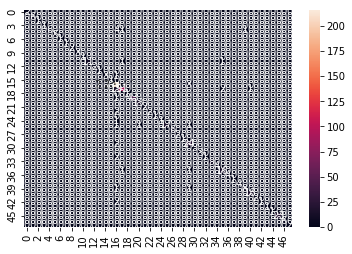

In [75]:
sns.heatmap(confusion_matrix(y_real, y_pre), annot=True)

In [76]:
Print_data(y_real, y_pre)

for class 0: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 1: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 2: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 3: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 4: recall 0.5, specificity 1.0            precision 1.0, f1 0.6667
for class 5: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 6: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 7: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 8: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 9: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 10: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 11: recall 0.8462, specificity 1.0            precision 1.0, f1 0.9167
for class 12: recall 1.0, specificity 1.0            precision 1.0, f1 1.0
for class 13: recall 1.0, 